Initializing the FisheyeRectConverter...
Initialization complete.
Performing the conversion...
Conversion complete.


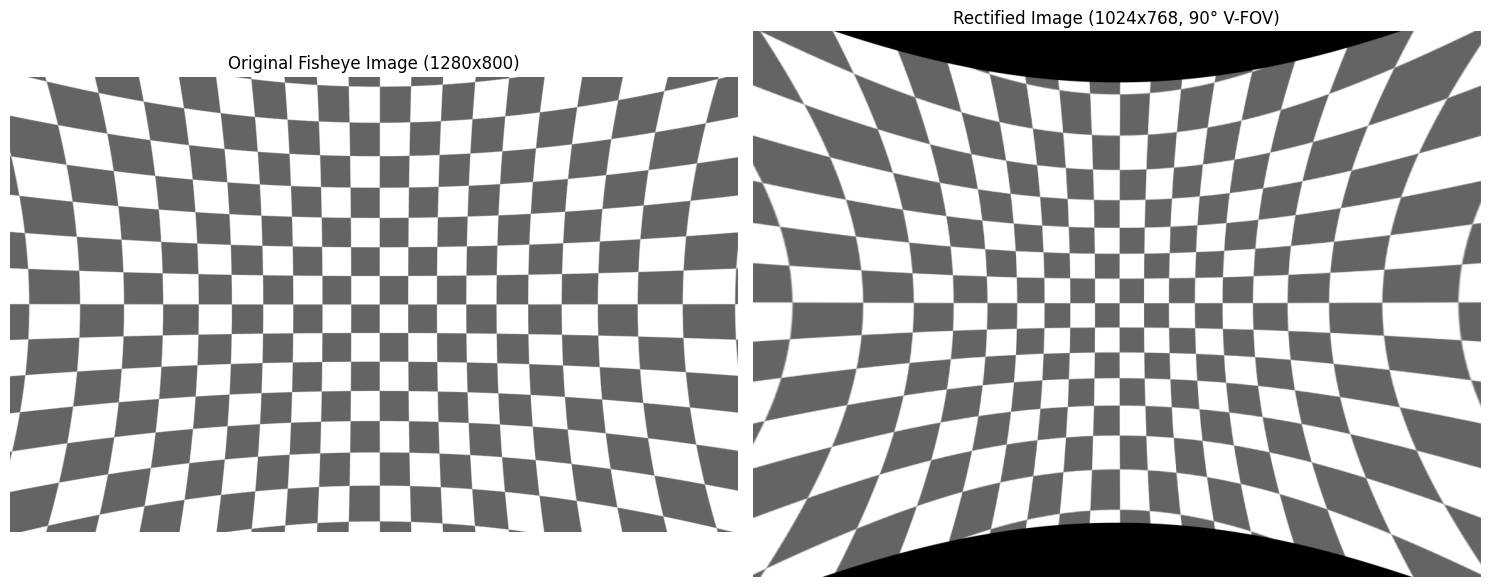

In [1]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. THE CLASS AND HELPER FUNCTION (from your code)
# -----------------------------------------------------------------------------

def parse_fisheye_intrinsics(intr_dict):
    """
    A plausible implementation for your helper function.
    It converts lists from the JSON into NumPy arrays as required by OpenCV.
    """
    K = np.array(intr_dict['K'], dtype=np.float32)
    D = np.array(intr_dict['D'], dtype=np.float32)
    DIM = tuple(intr_dict['DIM'])
    return {'K': K, 'D': D, 'DIM': DIM}

class FisheyeRectConverter:
    def __init__(self, K, D, DIM, out_size, out_fov):
        out_size = np.array(out_size)
        # vertical fov
        out_f = (out_size[1] / 2) / np.tan(out_fov / 180 * np.pi / 2)
        out_K = np.array(
            [[out_f, 0, out_size[0] / 2], [0, out_f, out_size[1] / 2], [0, 0, 1]],
            dtype=np.float32,
        )
        # Create the undistortion and rectification maps
        map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), out_K, out_size, cv2.CV_16SC2)

        self.map1 = map1
        self.map2 = map2

    def forward(self, img):
        # Apply the pre-computed maps to an image
        rect_img = cv2.remap(
            img,
            self.map1,
            self.map2,
            interpolation=cv2.INTER_AREA,
            borderMode=cv2.BORDER_CONSTANT,
        )
        return rect_img

# -----------------------------------------------------------------------------
# 2. SAMPLE DATA AND PARAMETERS
# -----------------------------------------------------------------------------

# Sample intrinsic data (as if loaded from a JSON file)
intrinsics_data = {
  "DIM": [1280, 800],
  "K": [
    [560.0, 0.0, 645.0],
    [0.0, 560.0, 402.0],
    [0.0, 0.0, 1.0]
  ],
  "D": [0.15, -0.08, 0.005, -0.001]
}

# Desired output parameters
output_resolution = (1024, 768)  # Desired output image size (width, height)
output_vertical_fov = 90         # Desired output vertical FOV in degrees

# Create a sample synthetic fisheye image for demonstration
# A checkerboard pattern is great for visualizing distortion
def create_sample_fisheye_image(dim):
    w, h = dim
    img = np.zeros((h, w, 3), dtype=np.uint8)
    square_size = 50
    for y in range(0, h, square_size):
        for x in range(0, w, square_size):
            if ((x // square_size) % 2 == 0) ^ ((y // square_size) % 2 == 0):
                img[y:y+square_size, x:x+square_size] = [255, 255, 255] # White
            else:
                img[y:y+square_size, x:x+square_size] = [100, 100, 100] # Gray
    
    # This is a dummy distortion effect for visualization purposes
    # Real fisheye images have this kind of barrel distortion naturally
    K = np.array(intrinsics_data['K'])
    D = np.array(intrinsics_data['D'])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, tuple(dim), cv2.CV_32FC1)
    # Applying the inverse map to a rectified image creates a distorted one
    distorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR)
    return distorted_img

fisheye_image = create_sample_fisheye_image(intrinsics_data["DIM"])


# -----------------------------------------------------------------------------
# 3. USAGE (mimicking your legacy system's logic)
# -----------------------------------------------------------------------------

# Step 1: Parse the intrinsics dictionary
opencv_intr_dict = parse_fisheye_intrinsics(intrinsics_data)

# Step 2: Initialize the converter. This does the heavy calculation once.
print("Initializing the FisheyeRectConverter...")
fisheye_converter = FisheyeRectConverter(
    **opencv_intr_dict,
    out_size=output_resolution,
    out_fov=output_vertical_fov
)
print("Initialization complete.")

# Step 3: Run the conversion on the sample image
print("Performing the conversion...")
rectified_image = fisheye_converter.forward(fisheye_image)
print("Conversion complete.")


# -----------------------------------------------------------------------------
# 4. VISUALIZE THE RESULTS
# -----------------------------------------------------------------------------
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title(f"Original Fisheye Image ({intrinsics_data['DIM'][0]}x{intrinsics_data['DIM'][1]})")
plt.imshow(cv2.cvtColor(fisheye_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Rectified Image ({output_resolution[0]}x{output_resolution[1]}, {output_vertical_fov}° V-FOV)")
plt.imshow(cv2.cvtColor(rectified_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()